In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
import missingno as msno
from itertools import cycle
from sklearn.metrics import mean_absolute_error
%load_ext autoreload
%autoreload 2
np.random.seed()
tqdm.pandas()

C:\Users\MANUJO~1\AppData\Local\Temp/ipykernel_21092/490912285.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_2", exist_ok=True)
preprocessed = Path("data/london_smart_meters/proprocessed")

In [4]:
def format_plot(fig, legends = None, font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": title_font_size
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text="Value",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text="Day",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

# Reading Blocks 0-7

In [5]:
from src.utils.data_utils import compact_to_expanded

In [6]:
block_df = pd.read_parquet("data/london_smart_meters/preprocessed/london_smart_meters_merged_block_0-7.parquet")

block_df.head()

LCLid start_timestamp frequency  \
0  MAC000002      2012-10-13     30min   
1  MAC000246      2012-01-01     30min   
2  MAC000450      2012-03-23     30min   
3  MAC001074      2012-05-09     30min   
4  MAC003223      2012-09-18     30min   

                                  energy_consumption  series_length stdorToU  \
0  [0.263, 0.2689999999999999, 0.275, 0.256, 0.21...          24144      Std   
1  [0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...          37872      Std   
2  [1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...          33936      Std   
3  [0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...          31680      ToU   
4  [0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...          25344      Std   

     Acorn Acorn_grouped     file  \
0  ACORN-A      Affluent  block_0   
1  ACORN-A      Affluent  block_0   
2  ACORN-A      Affluent  block_0   
3   ACORN-        ACORN-  block_0   
4  ACORN-A      Affluent  block_0   

                                            holidays  ...  \
0  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
1  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
2  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
3  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   
4  [NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...  ...   

                                         windBearing  \
0  [186, 186, 188, 188, 190, 190, 203, 203, 206, ...   
1  [229, 229, 238, 238, 229, 229, 231, 231, 227, ...   
2  [78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...   
3  [215, 215, 207, 207, 215, 215, 216, 216, 126, ...   
4  [236, 236, 240, 240, 242, 242, 244, 244, 248, ...   

                                         temperature  \
0  [8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                            dewPoint  \
0  [6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...   
1  [10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....   
2  [7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...   
3  [10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....   
4  [10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...   

                                            pressure  \
0  [1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...   
1  [1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...   
2  [1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...   
3  [1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...   
4  [1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...   

                                 apparentTemperature  \
0  [7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...   
1  [12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....   
2  [7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...   
3  [11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....   
4  [14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....   

                                           windSpeed  \
0  [2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...   
1  [5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...   
2  [2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...   
3  [2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...   
4  [3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...   

                                          precipType  \
0  [rain, rain, rain, rain, rain, rain, rain, rai...   
1  [rain, rain, rain, rain, rain, rain, rain, rai...   
2  [rain, rain, rain, rain, rain, rain, rain, rai...   
3  [rain, rain, rain, rain, rain, rain, rain, rai...   
4  [rain, rain, rain, rain, rain, rain, rain, rai...   

                                                icon  \
0  [clear-night, clear-night, clear-night, clear-...   
1  [partly-cloudy-night, partly-cloudy-night, clo...   
2  [fog, fog, fog, fog, fog, fog, fog, fog, fog, ...   
3  [partly-cloudy-night, partly-cloudy-night, par...   
4  [clear-night, clear-night, clear-night, c

Let's take all the consumers in one block for our exercise. Keep in mind, you can do the same with more number of blocks as long as it fits in your RAM

In [7]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000050               0.175     30min          37872   
1 2012-01-01 00:30:00  MAC000050               0.212     30min          37872   
2 2012-01-01 01:00:00  MAC000050               0.313     30min          37872   
3 2012-01-01 01:30:00  MAC000050               0.302     30min          37872   
4 2012-01-01 02:00:00  MAC000050               0.257     30min          37872   

  stdorToU    Acorn Acorn_grouped     file    holidays  ...  windBearing  \
0      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
1      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   
2      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
3      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          238   
4      Std  ACORN-D      Affluent  block_7  NO_HOLIDAY  ...          229   

   temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0        12.12     10.97   1008.10                12.12       5.90   
1        12.12     10.97   1008.10                12.12       5.90   
2        12.59     11.02   1007.88                12.59       6.06   
3        12.59     11.02   1007.88                12.59       6.06   
4        12.45     11.04   1007.95                12.45       5.31   

   precipType                 icon humidity        summary  
0        rain  partly-cloudy-night     0.93  Mostly Cloudy  
1        rain  partly-cloudy-night     0.93  Mostly Cloudy  
2        rain               cloudy     0.90       Overcast  
3        rain               cloudy     0.90       Overcast  
4        rain  partly-cloudy-night     0.91  Mostly Cloudy  

[5 rows x 21 columns]

# Missing Data and Advanced Imputation Techniques

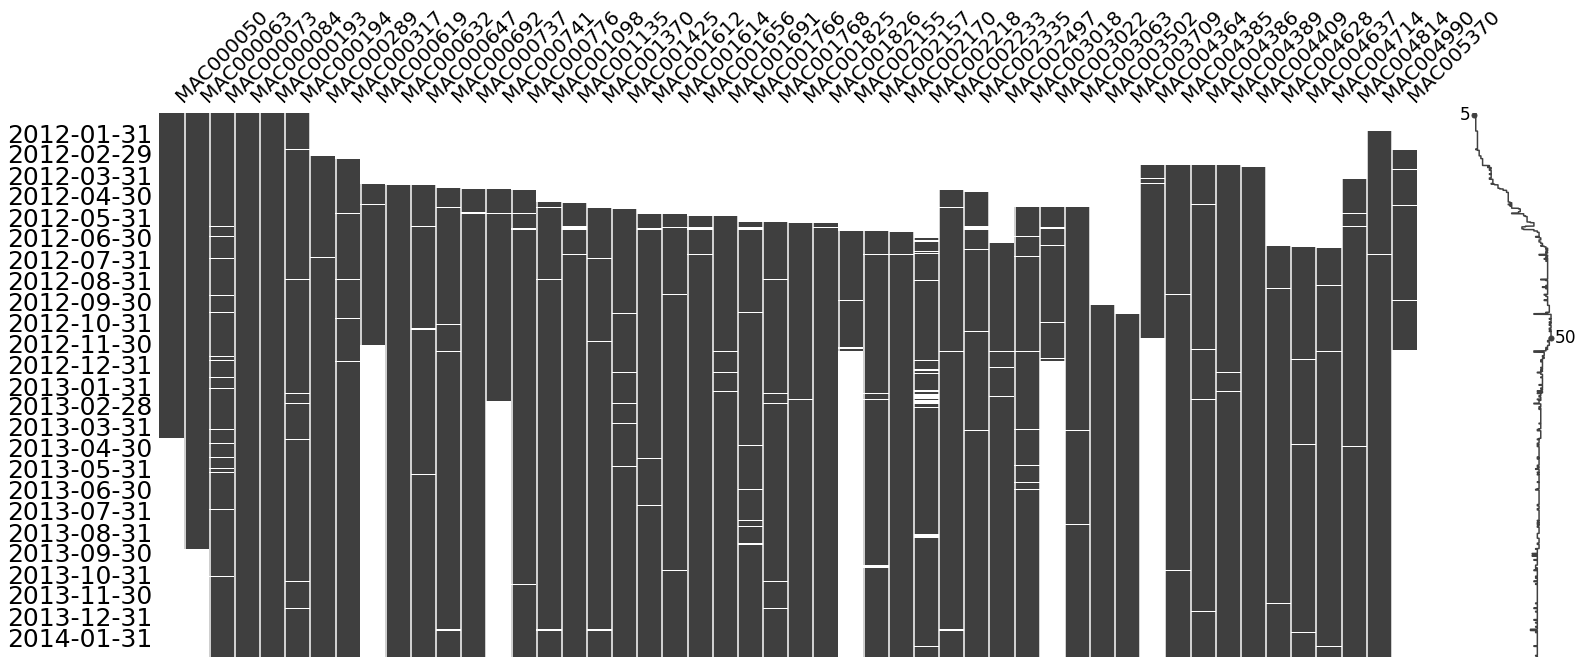

In [8]:
# Pivot the data to set the index as the datetime and the different time series along the columns
plot_df = pd.pivot_table(exp_block_df, index="timestamp", columns="LCLid", values="energy_consumption")
# Generate Plot. Since we have a datetime index, we can mention the frequency to decide what do we want on the X axis
msno.matrix(plot_df, freq="M", fontsize=20)
plt.savefig('imgs/chapter_2/missing_no_full.png', bbox_inches='tight')
plt.show()

In [8]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

We know that there is some missing data between 2012-09-30 and 2012-10-31. But instead of picking a window where there is an actual missing data, let's pick a window where data is present, but we artificially remove it and then look at techniques to fill it. This way, we can have some way to see how well a particular method is working.

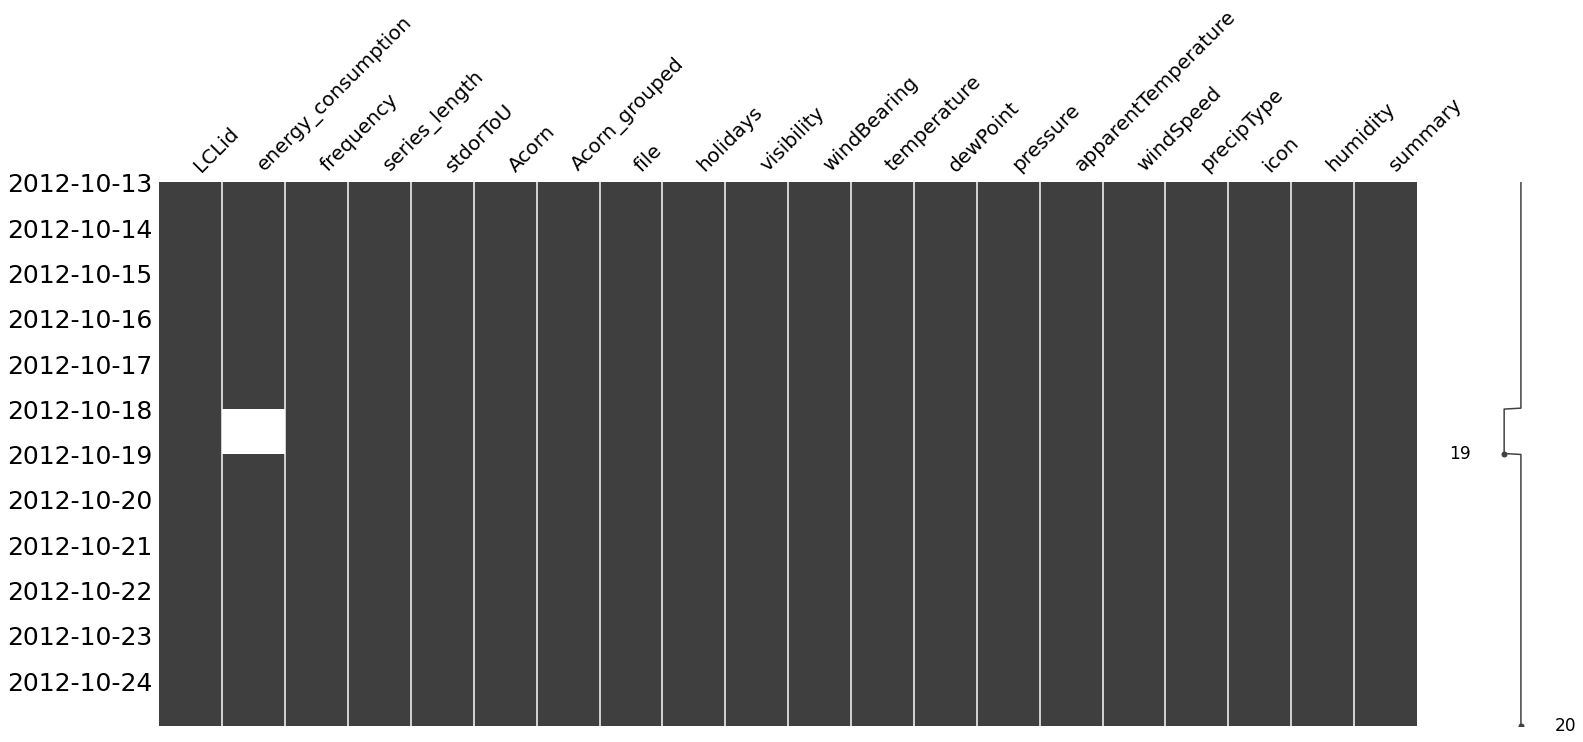

In [16]:
msno.matrix(ts_df["2012-10-13": "2012-10-24"], freq="D", fontsize=20)
plt.savefig('imgs/chapter_2/missing_no_mac000193.png', bbox_inches='tight')
plt.show()

We see that there are two days of information and normally would preceed to fill in the gaps using some of the techniques we will be revieweing. But just to see how effective the different techniques we are reviewing, we will artificially create a missing section and see how well we are able to impute it.

In [9]:
# The dates between which we are nulling out the time series
window = slice("2012-10-07", "2012-10-08")
# Creating a new column and artificially creating missing values
ts_df['energy_consumption_missing'] = ts_df.energy_consumption
ts_df.loc[window, "energy_consumption_missing"] = np.nan
# Creating a new window with a few dats added on either side for visualization purposes
vis_window = slice(pd.to_datetime(window.start) - pd.Timedelta(days=2), pd.to_datetime(window.stop) + pd.Timedelta(days=2))

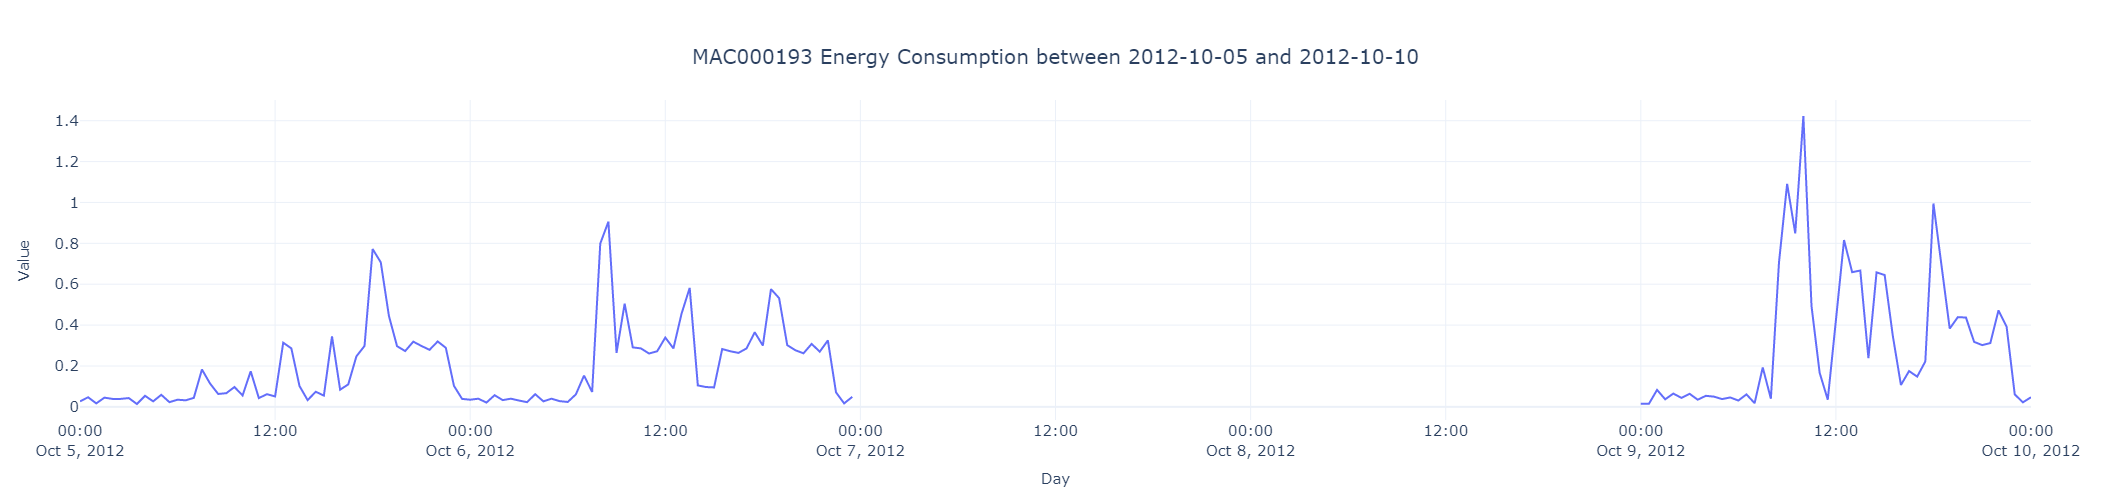

In [10]:
fig = px.line(ts_df[vis_window], y="energy_consumption_missing", title=f"MAC000193 Energy Consumption between {vis_window.start.strftime('%Y-%m-%d')} and {vis_window.stop.strftime('%Y-%m-%d')}")
fig = format_plot(fig)
fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

## Missing Data Imputation

In [11]:
null_mask = ts_df.energy_consumption_missing.isnull()

### Repeating Patterns

#### Last Day

In [12]:
#Shifting 48 steps to get previous day
ts_df["prev_day"] = ts_df['energy_consumption'].shift(48)
#Using the shifted column to fill missing
ts_df['prev_day_imputed'] =  ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"prev_day_imputed"] = ts_df.loc[null_mask,"prev_day"]
mae = mean_absolute_error(ts_df.loc[window, "prev_day_imputed"], ts_df.loc[window, "energy_consumption"])

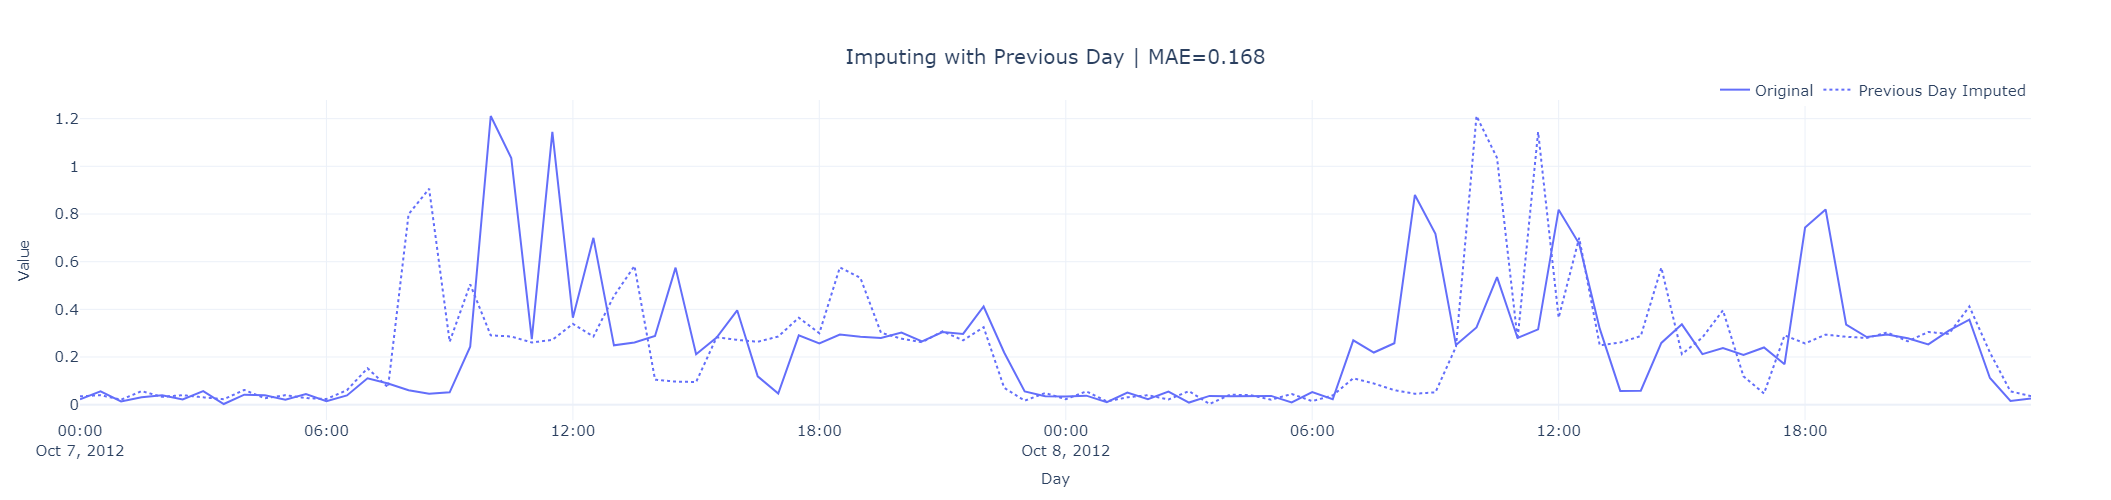

In [22]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','prev_day_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Previous Day | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Previous Day Imputed'])
fig.write_image("imgs/chapter_2/previous_day_imputation.png")
fig

#### Hourly Profile

In [13]:
#Create a column with the Hour from timestamp
ts_df["hour"] = ts_df.index.hour
#Calculate hourly average consumption
hourly_profile = ts_df.groupby(['hour'])['energy_consumption'].mean().reset_index()
hourly_profile.rename(columns={"energy_consumption": "hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the hourly profile dataframe to ts dataframe
ts_df = ts_df.merge(hourly_profile, on=['hour'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the hourly profile to fill missing
ts_df['hourly_profile_imputed'] = ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"hourly_profile_imputed"] = ts_df.loc[null_mask,"hourly_profile"]
mae = mean_absolute_error(ts_df.loc[window, "hourly_profile_imputed"], ts_df.loc[window, "energy_consumption"])

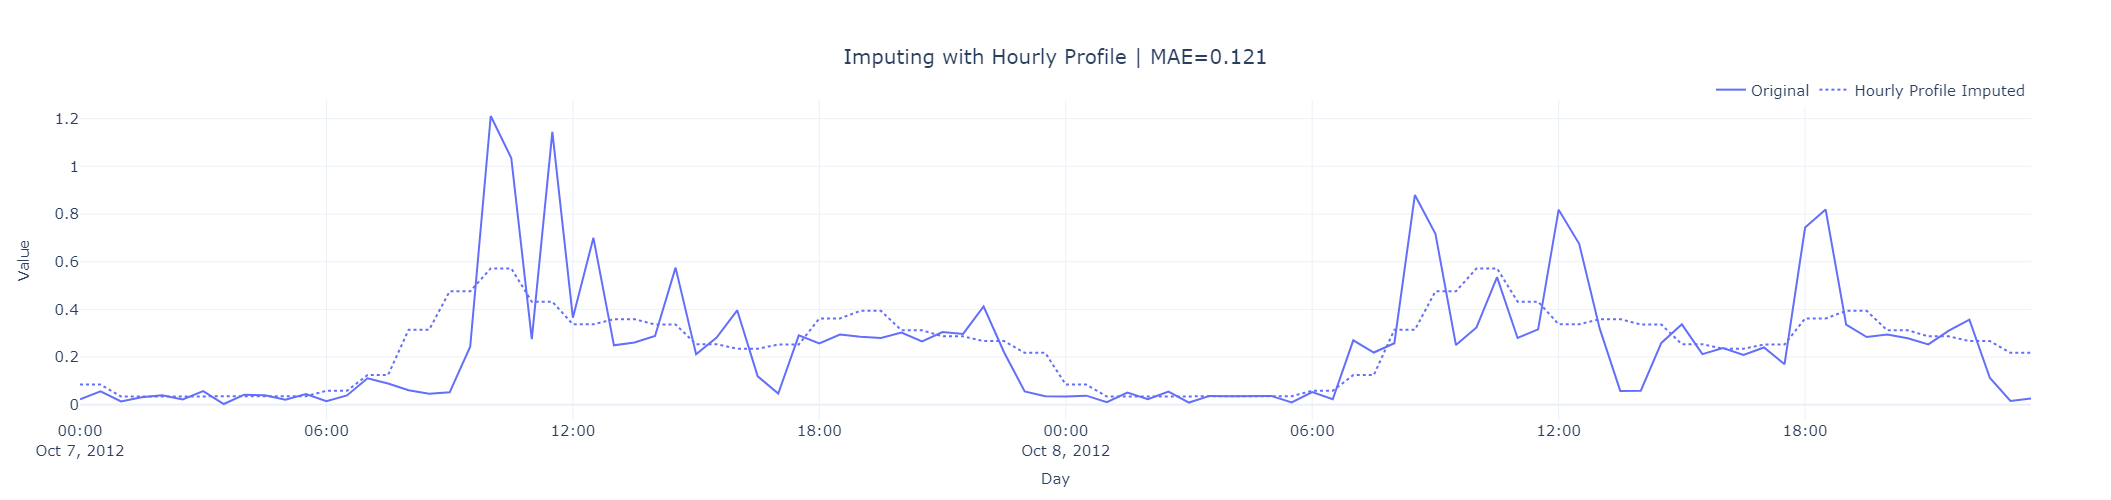

In [24]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Hourly Profile Imputed'])
fig.write_image("imgs/chapter_2/hourly_profile_imputation.png")
fig

#### Weekday-Hourly Profile

In [14]:
#Create a column with the weekday from timestamp
ts_df["weekday"] = ts_df.index.weekday
#Calculate weekday-hourly average consumption
day_hourly_profile = ts_df.groupby(['weekday','hour'])['energy_consumption'].mean().reset_index()
day_hourly_profile.rename(columns={"energy_consumption": "day_hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the day-hourly profile dataframe to ts dataframe
ts_df = ts_df.merge(day_hourly_profile, on=['weekday', 'hour'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the day-hourly profile to fill missing
ts_df['day_hourly_profile_imputed'] = ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"day_hourly_profile_imputed"] = ts_df.loc[null_mask,"day_hourly_profile"]
mae = mean_absolute_error(ts_df.loc[window, "day_hourly_profile_imputed"], ts_df.loc[window, "energy_consumption"])

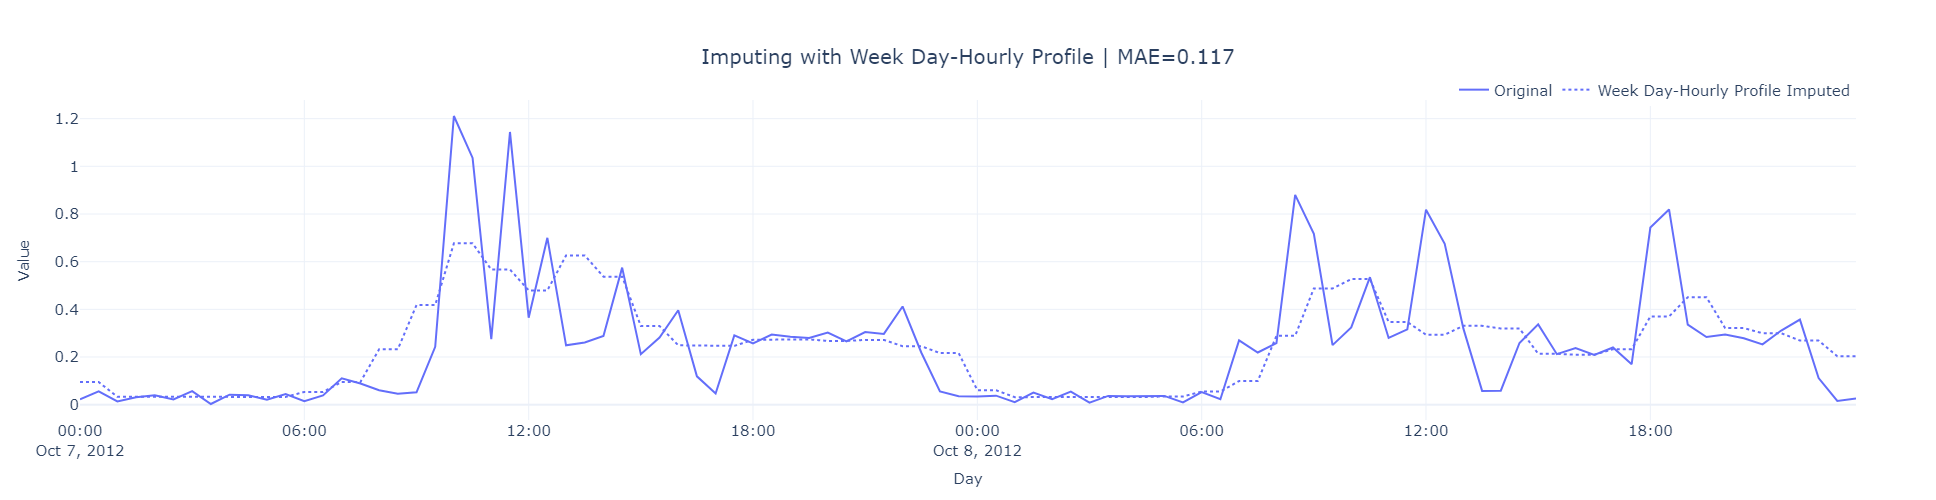

In [26]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','day_hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Week Day-Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Week Day-Hourly Profile Imputed'])
fig.write_image("imgs/chapter_2/day_hourly_profile_imputation.png")
fig

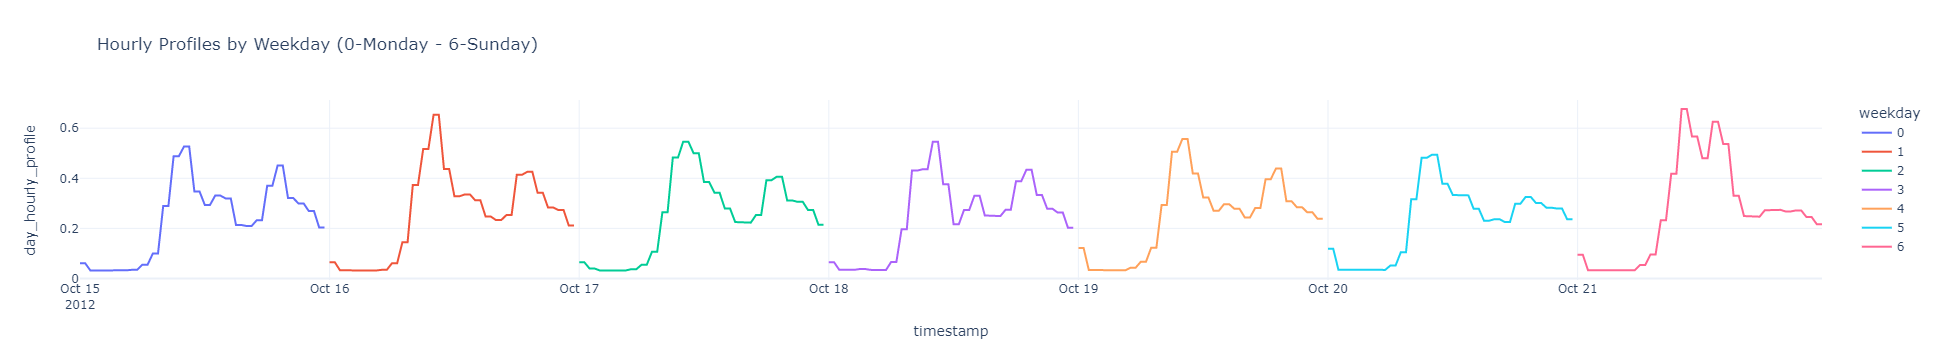

In [27]:
# Hourly Profiles by week Day
px.line(ts_df.loc["2012-10-15": "2012-10-21",['day_hourly_profile','weekday']].reset_index(), x="timestamp", y="day_hourly_profile", color='weekday', title="Hourly Profiles by Weekday (0-Monday - 6-Sunday)")

#### Seasonal Interpolation

In [15]:
from src.imputation.interpolation import SeasonalInterpolation

In [16]:
# Seasonal interpolation using 48*7 as the seasonal period.
# seasonal period is the period after which you expect the pattern to repeat
recovered_matrix_seas_interp_weekday_half_hour = SeasonalInterpolation(seasonal_period=48*7,
                                                     decomposition_strategy="additive", 
                                                     interpolation_strategy="spline", 
                                                     interpolation_args={"order":3}, 
                                                     min_value=0).fit_transform(ts_df.energy_consumption_missing.values.reshape(-1,1))

ts_df['seas_interp_weekday_half_hour_imputed'] = recovered_matrix_seas_interp_weekday_half_hour
mae_weekday_half_hour = mean_absolute_error(ts_df.loc[window, "seas_interp_weekday_half_hour_imputed"], ts_df.loc[window, "energy_consumption"])

In [17]:
recovered_matrix_seas_interp_half_hour = SeasonalInterpolation(seasonal_period=48,
                                                     decomposition_strategy="additive", 
                                                     interpolation_strategy="spline", 
                                                     interpolation_args={"order":3}, 
                                                     min_value=0).fit_transform(ts_df.energy_consumption_missing.values.reshape(-1,1))

ts_df['seas_interp_half_hour_imputed'] = recovered_matrix_seas_interp_half_hour
mae_half_hour = mean_absolute_error(ts_df.loc[window, "seas_interp_half_hour_imputed"], ts_df.loc[window, "energy_consumption"])

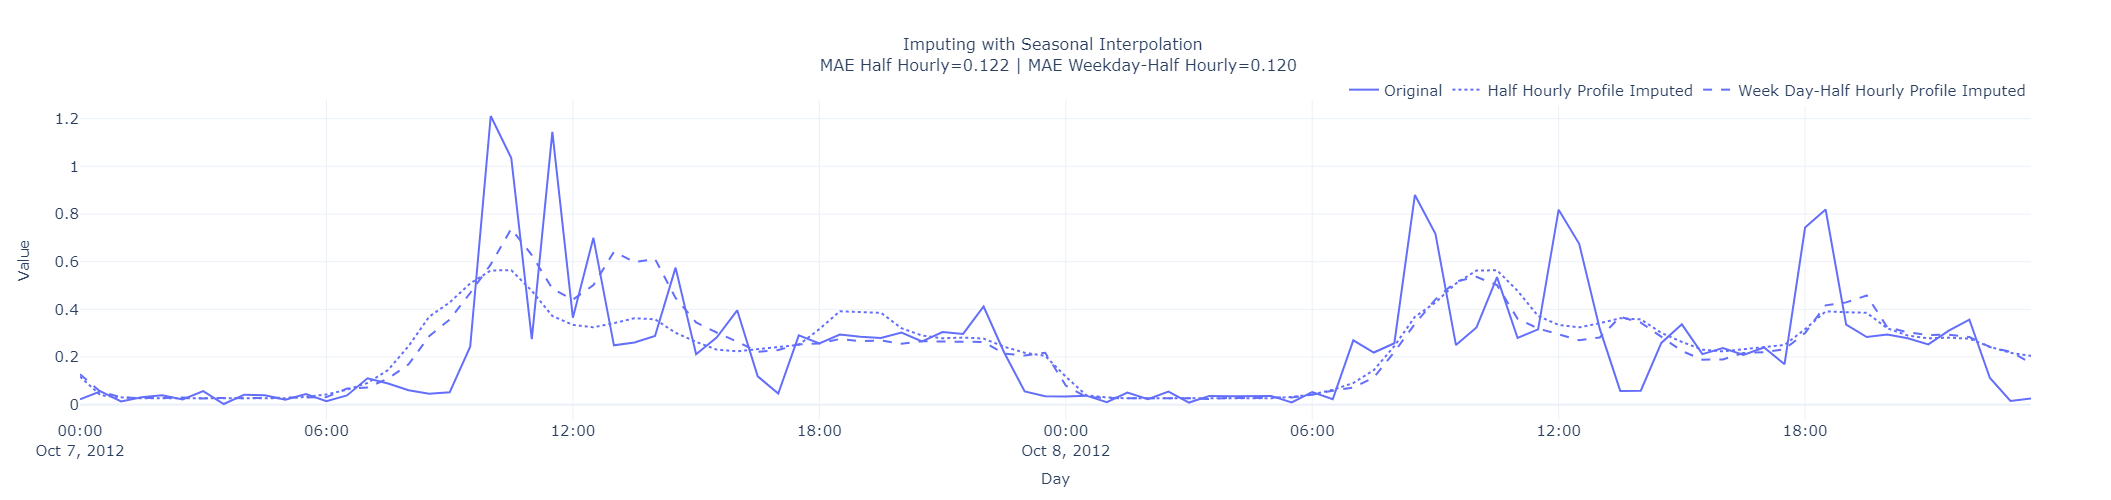

In [33]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption', "seas_interp_half_hour_imputed", 'seas_interp_weekday_half_hour_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Seasonal Interpolation <br> MAE Half Hourly={mae_half_hour:.3f} | MAE Weekday-Half Hourly={mae_weekday_half_hour:.3f}")
fig = format_plot(fig, ['Original', 'Half Hourly Profile Imputed', 'Week Day-Half Hourly Profile Imputed'], title_font_size=16)
fig.write_image("imgs/chapter_2/seasonal_interpolation_imputation.png")
fig

### Matrix Recovery

In [18]:
from fancyimpute import IterativeSVD, NuclearNormMinimization, SoftImpute, MatrixFactorization

**Important Note** - `fancyimpute` removed Tensorflow and Keras as dependencies in version `0.5.4 ` and consequently installation does not need a working tensorflow installation. While this is easier, if you have a GPU in your machine, reverting to `fancyimpute==0.5.4` will make the models so much faster. But I recommend cloning the environment using `conda create -n new_env --clone old_env` and then installing older version of fancyimpute to not mess us the main environment. After pip installing `fancyimpute==0.5.4`, chaeck if the keras version is 2.4.3. If not, downgrade keras==2.4.3.

Let's take all the time series in the block together

In [19]:
all_ts_df = pd.pivot_table(exp_block_df, index="timestamp", columns="LCLid", values="energy_consumption")
# Nulling out the window
all_ts_df.loc[window, "MAC000193"] = np.nan

#### Matrix Factorization

##### Grid Search Rank

In [ ]:
# mae_l = []
# rank_l = []
# for r in tqdm([10,20,30,40,50]):
#     recovered_matrix_mf = MatrixFactorization(rank=r).fit_transform(all_ts_df.values)
#     # Casting the array as the dataframe
#     filled_df = pd.DataFrame(recovered_matrix_mf, columns=all_ts_df.columns, index=all_ts_df.index)
#     #Joining with the ts_df and renaming the column
#     _ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
#     _ts_df.rename(columns={"MAC000193": "mf_10_recovered"}, inplace=True)
#     # Using the nf recovered to fill missing
#     _ts_df['mf_10_imputed'] = ts_df.energy_consumption_missing
#     _ts_df.loc[null_mask,"mf_10_imputed"] = _ts_df.loc[null_mask,"mf_10_recovered"]
#     mae = mean_absolute_error(_ts_df.loc[window, "mf_10_imputed"], _ts_df.loc[window, "energy_consumption"])
#     mae_l.append(mae)
#     rank_l.append(r)

# print(f"Best Rank is: {rank_l[np.argmin(mae_l)]}")

In [17]:
# Running Matrix Factorization with rank=10
recovered_matrix_mf = MatrixFactorization(rank=50).fit_transform(all_ts_df.values)

AttributeError: module 'keras.optimizers' has no attribute 'nadam'

In [29]:
#Casting the array as the dataframe
filled_df = pd.DataFrame(recovered_matrix_mf, columns=all_ts_df.columns, index=all_ts_df.index)
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "mf_50_recovered"}, inplace=True)
#Using the nf recovered to fill missing
ts_df['mf_50_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"mf_50_imputed"] = ts_df.loc[null_mask,"mf_50_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "mf_50_imputed"], ts_df.loc[window, "energy_consumption"])

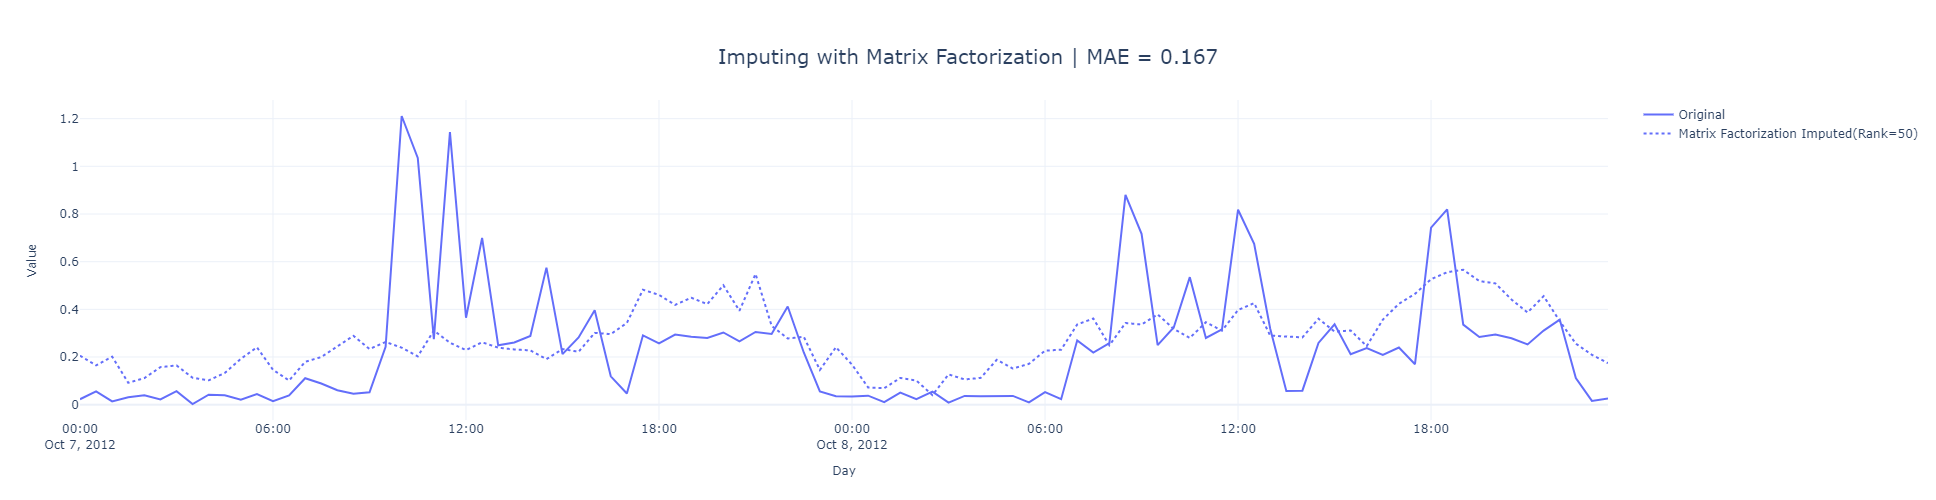

In [30]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption', 'mf_50_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Matrix Factorization | MAE = {mae:.3f}")
fig = format_plot(fig, ['Original', 'Matrix Factorization Imputed(Rank=50)'])
fig.write_image("imgs/chapter_2/mf_imputation.png")
fig

#### Truncated SVD

In [31]:
from src.imputation.matrix_recovery import TruncatedSVDImputation

##### Grid Search Rank

In [32]:
# mae_l = []
# rank_l = []
# for r in tqdm([2, 5,10,15,20,25,30,35,40]):
#     recovered_matrix_tsvd = TruncatedSVDImputation(rank=r, init_fill_method="zero", min_value=0).fit_transform(all_ts_df.values)
#     # Casting the array as the dataframe
#     filled_df = pd.DataFrame(recovered_matrix_tsvd, columns=all_ts_df.columns, index=all_ts_df.index)
#     #Joining with the ts_df and renaming the column
#     _ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
#     _ts_df.rename(columns={"MAC000193": "tsvd_recovered"}, inplace=True)
#     # Using the nf recovered to fill missing
#     _ts_df['tsvd_imputed'] = ts_df.energy_consumption_missing
#     _ts_df.loc[null_mask,"tsvd_imputed"] = _ts_df.loc[null_mask,"tsvd_recovered"]
#     mae = mean_absolute_error(_ts_df.loc[window, "tsvd_imputed"], _ts_df.loc[window, "energy_consumption"])
#     mae_l.append(mae)
#     rank_l.append(r)
    
# print(f"Best Rank is: {rank_l[np.argmin(mae_l)]}")

In [33]:
# Running Truncated SVD with rank=2
recovered_matrix_tsvd = TruncatedSVDImputation(rank=2, init_fill_method="zero", min_value=0).fit_transform(all_ts_df.values)

[Truncated SVD] Truncated SVD complete with MAE: 0.158607


In [34]:
#Casting the array as the dataframe
filled_df = pd.DataFrame(recovered_matrix_tsvd, columns=all_ts_df.columns, index=all_ts_df.index)
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "tsvd_recovered"}, inplace=True)
#Using the nf recovered to fill missing
ts_df['tsvd_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"tsvd_imputed"] = ts_df.loc[null_mask,"tsvd_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "tsvd_imputed"], ts_df.loc[window, "energy_consumption"])

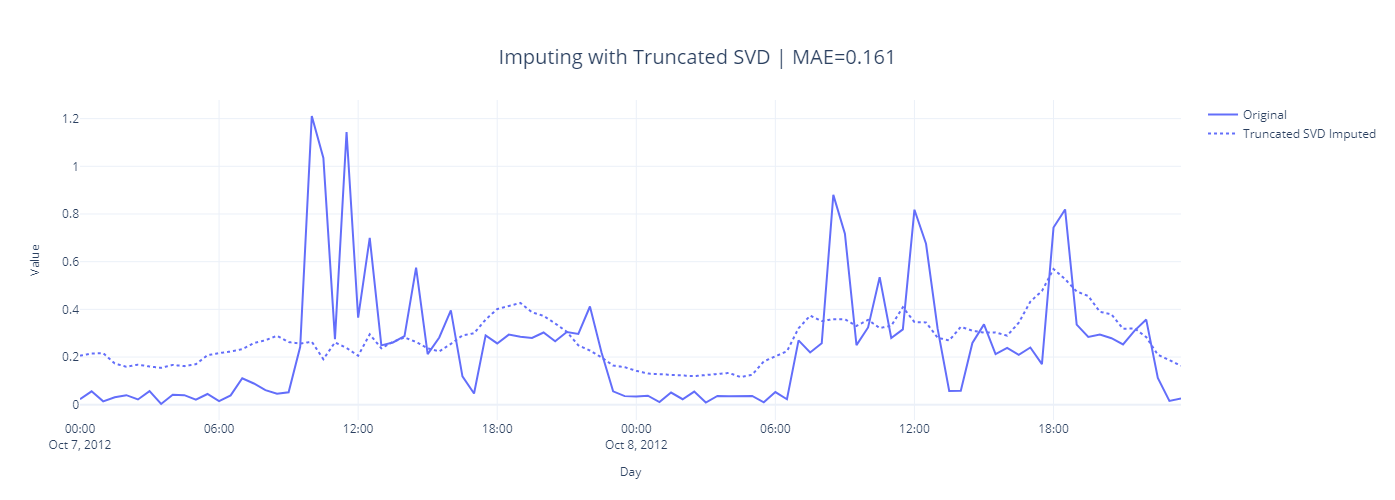

In [35]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','tsvd_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Truncated SVD | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Truncated SVD Imputed'])
fig.write_image("imgs/chapter_2/tsvd_imputation.png")
fig

#### Iterative SVD

##### Grid Search Rank

In [36]:
# mae_l = []
# rank_l = []
# for r in tqdm([2,5,10,15,20,30,40]):
#     recovered_matrix_mf = IterativeSVD(rank=r, max_iters=1000, svd_algorithm="arpack", min_value=0).fit_transform(all_ts_df.values)
#     # Casting the array as the dataframe
#     filled_df = pd.DataFrame(recovered_matrix_mf, columns=all_ts_df.columns, index=all_ts_df.index)
#     #Joining with the ts_df and renaming the column
#     _ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
#     _ts_df.rename(columns={"MAC000193": "isvd_recovered"}, inplace=True)
#     # Using the nf recovered to fill missing
#     _ts_df['isvd_imputed'] = ts_df.energy_consumption_missing
#     _ts_df.loc[null_mask,"isvd_imputed"] = _ts_df.loc[null_mask,"isvd_recovered"]
#     mae = mean_absolute_error(_ts_df.loc[window, "isvd_imputed"], _ts_df.loc[window, "energy_consumption"])
#     mae_l.append(mae)
#     rank_l.append(r)
    
# print(f"Best Rank is: {rank_l[np.argmin(mae_l)]}")

In [37]:
# Running Iterative SVD with rank=2
recovered_matrix_isvd = IterativeSVD(rank=2, max_iters=1000, svd_algorithm="arpack", min_value=0).fit_transform(all_ts_df.values)

[IterativeSVD] Iter 1: observed MAE=0.166608
[IterativeSVD] Iter 2: observed MAE=0.156911
[IterativeSVD] Iter 3: observed MAE=0.156449
[IterativeSVD] Iter 4: observed MAE=0.156226
[IterativeSVD] Iter 5: observed MAE=0.156029
[IterativeSVD] Iter 6: observed MAE=0.155829
[IterativeSVD] Iter 7: observed MAE=0.155628
[IterativeSVD] Iter 8: observed MAE=0.155435
[IterativeSVD] Iter 9: observed MAE=0.155254
[IterativeSVD] Iter 10: observed MAE=0.155086
[IterativeSVD] Iter 11: observed MAE=0.154931
[IterativeSVD] Iter 12: observed MAE=0.154789
[IterativeSVD] Iter 13: observed MAE=0.154656
[IterativeSVD] Iter 14: observed MAE=0.154533
[IterativeSVD] Iter 15: observed MAE=0.154419
[IterativeSVD] Iter 16: observed MAE=0.154314
[IterativeSVD] Iter 17: observed MAE=0.154217
[IterativeSVD] Iter 18: observed MAE=0.154127
[IterativeSVD] Iter 19: observed MAE=0.154045
[IterativeSVD] Iter 20: observed MAE=0.153970
[IterativeSVD] Iter 21: observed MAE=0.153899
[IterativeSVD] Iter 22: observed MAE=0.1538

In [38]:
#Casting the array as the dataframe
filled_df = pd.DataFrame(recovered_matrix_isvd, columns=all_ts_df.columns, index=all_ts_df.index)
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "isvd_recovered"}, inplace=True)
#Using the nf recovered to fill missing
ts_df['isvd_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"isvd_imputed"] = ts_df.loc[null_mask,"isvd_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "isvd_imputed"], ts_df.loc[window, "energy_consumption"])

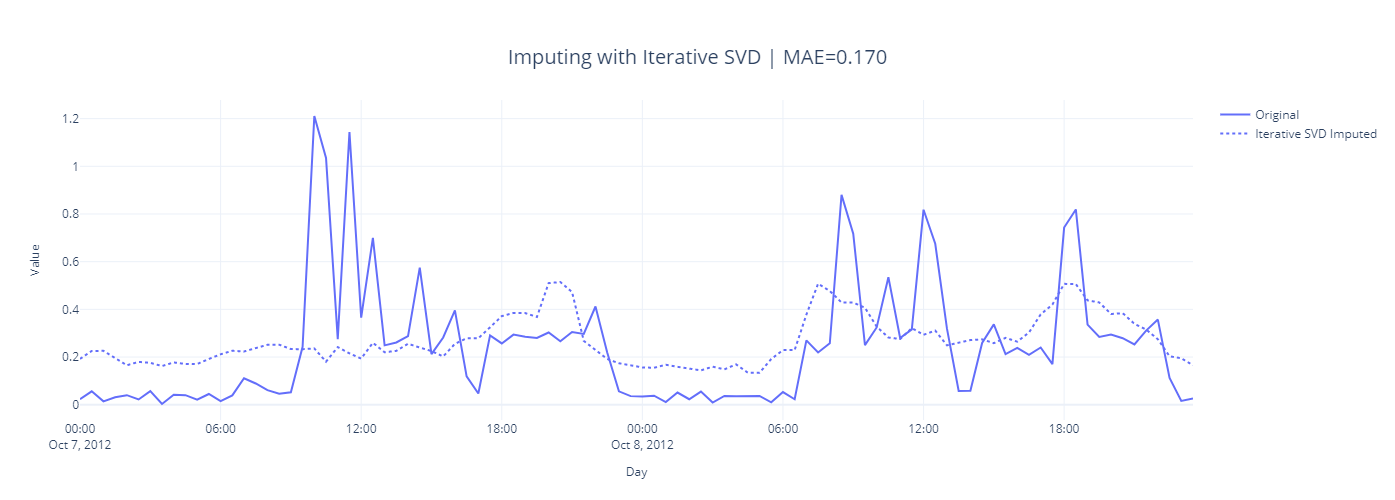

In [39]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','isvd_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Iterative SVD | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Iterative SVD Imputed'])
fig.write_image("imgs/chapter_2/isvd_imputation.png")
fig

#### SoftImpute

##### Grid Search Shrinkage Value

Finding out what kind of singular values the matrix has and setting the grid to cover that range

In [40]:
# from sklearn.utils.extmath import randomized_svd
# # quick decomposition of X_filled into rank-1 SVD
# _, s, _ = randomized_svd(
#     all_ts_df.fillna(0).values,
#     10,
#     n_iter=5)
# print(f"The Singular Values are: {s}")

Running Grid Search around the range of singular values

In [41]:
# mae_l = []
# rank_l = []
# for r in tqdm([60, 70, 80, 90, 100, 150, 250]):
#     recovered_matrix = SoftImpute(r, max_iters=1000, min_value=0).fit_transform(all_ts_df.values)
#     # Casting the array as the dataframe
#     filled_df = pd.DataFrame(recovered_matrix, columns=all_ts_df.columns, index=all_ts_df.index)
#     #Joining with the ts_df and renaming the column
#     _ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
#     _ts_df.rename(columns={"MAC000193": "recovered"}, inplace=True)
#     # Using the nf recovered to fill missing
#     _ts_df['imputed'] = ts_df.energy_consumption_missing
#     _ts_df.loc[null_mask,"imputed"] = _ts_df.loc[null_mask,"recovered"]
#     mae = mean_absolute_error(_ts_df.loc[window, "imputed"], _ts_df.loc[window, "energy_consumption"])
#     mae_l.append(mae)
#     rank_l.append(r)
    
# print(f"Best Shrinkage Value is: {rank_l[np.argmin(mae_l)]}")

In [20]:
# Running Soft Impute with shrinkage=70
recovered_matrix_si = SoftImpute(shrinkage_value=70, max_iters=1000, min_value=0).fit_transform(all_ts_df.values)

[SoftImpute] Max Singular Value of X_init = 449.140691
[SoftImpute] Iter 1: observed MAE=0.146140 rank=8
[SoftImpute] Iter 2: observed MAE=0.145738 rank=8
[SoftImpute] Iter 3: observed MAE=0.145613 rank=7
[SoftImpute] Iter 4: observed MAE=0.145572 rank=7
[SoftImpute] Iter 5: observed MAE=0.145566 rank=7
[SoftImpute] Iter 6: observed MAE=0.145564 rank=6
[SoftImpute] Iter 7: observed MAE=0.145541 rank=6
[SoftImpute] Iter 8: observed MAE=0.145525 rank=6
[SoftImpute] Iter 9: observed MAE=0.145512 rank=6
[SoftImpute] Iter 10: observed MAE=0.145502 rank=6
[SoftImpute] Iter 11: observed MAE=0.145496 rank=6
[SoftImpute] Iter 12: observed MAE=0.145493 rank=6
[SoftImpute] Iter 13: observed MAE=0.145492 rank=6
[SoftImpute] Iter 14: observed MAE=0.145492 rank=6
[SoftImpute] Iter 15: observed MAE=0.145494 rank=6
[SoftImpute] Iter 16: observed MAE=0.145496 rank=6
[SoftImpute] Iter 17: observed MAE=0.145498 rank=6
[SoftImpute] Iter 18: observed MAE=0.145500 rank=6
[SoftImpute] Iter 19: observed MAE=0

In [21]:
# Casting the array as the dataframe
filled_df = pd.DataFrame(recovered_matrix_si, columns=all_ts_df.columns, index=all_ts_df.index)
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "si_recovered"}, inplace=True)
# Using the nf recovered to fill missing
ts_df['si_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"si_imputed"] = ts_df.loc[null_mask,"si_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "si_imputed"], ts_df.loc[window, "energy_consumption"])

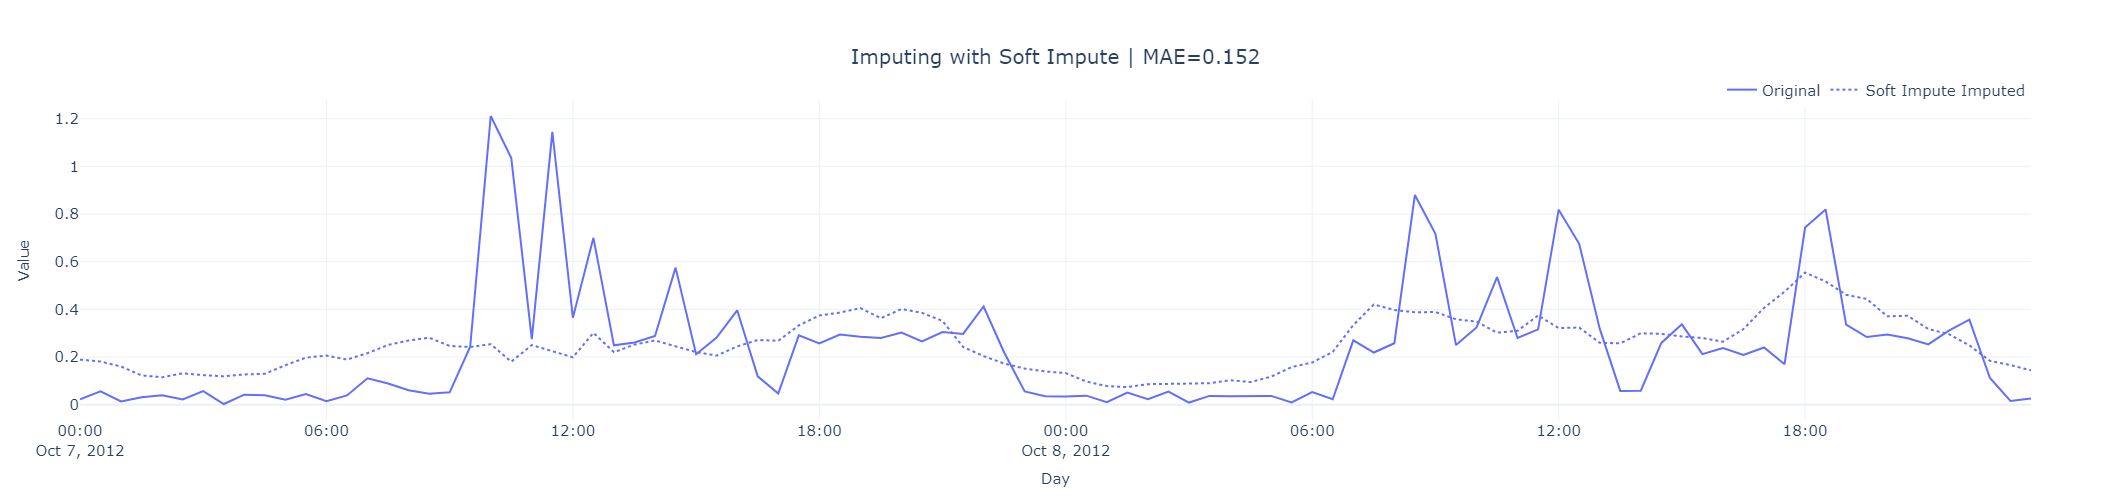

In [22]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','si_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Soft Impute | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Soft Impute Imputed'])
fig.write_image("imgs/chapter_2/soft_impute_imputation.png")
fig

#### CDRec

In [45]:
from src.imputation.matrix_recovery import CentroidRecovery

##### Grid Search Rank

In [55]:
# mae_l = []
# rank_l = []
# for r in tqdm([2, 3, 4,5, 6, 8, 10, 12, 14, 16, 20,30,40]):
#     recovered_matrix = CentroidRecovery(truncation=r, max_iters=100, init_fill_method="interpolate", min_value=0, early_stopping=True).fit_transform(all_ts_df.values)
#     # Casting the array as the dataframe
#     filled_df = pd.DataFrame(recovered_matrix, columns=all_ts_df.columns, index=all_ts_df.index)
#     #Joining with the ts_df and renaming the column
#     _ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
#     _ts_df.rename(columns={"MAC000193": "recovered"}, inplace=True)
#     # Using the nf recovered to fill missing
#     _ts_df['imputed'] = ts_df.energy_consumption_missing
#     _ts_df.loc[null_mask,"imputed"] = _ts_df.loc[null_mask,"recovered"]
#     mae = mean_absolute_error(_ts_df.loc[window, "imputed"], _ts_df.loc[window, "energy_consumption"])
#     mae_l.append(mae)
#     rank_l.append(r)
    
# print(f"Best Rank is: {rank_l[np.argmin(mae_l)]}")

  0%|          | 0/13 [00:00<?, ?it/s]

[CentroidRecovery] Iter 2: observed MAE=0.174113 Best Iteration: 2 Best MAE: 0.174113
[CentroidRecovery] Iter 3: observed MAE=0.171045 Best Iteration: 3 Best MAE: 0.171045
[CentroidRecovery] Iter 4: observed MAE=0.169502 Best Iteration: 4 Best MAE: 0.169502
[CentroidRecovery] Iter 5: observed MAE=0.167817 Best Iteration: 5 Best MAE: 0.167817
[CentroidRecovery] Iter 6: observed MAE=0.166305 Best Iteration: 6 Best MAE: 0.166305
[CentroidRecovery] Iter 7: observed MAE=0.165197 Best Iteration: 7 Best MAE: 0.165197
[CentroidRecovery] Iter 8: observed MAE=0.164324 Best Iteration: 8 Best MAE: 0.164324
[CentroidRecovery] Iter 9: observed MAE=0.163666 Best Iteration: 9 Best MAE: 0.163666
[CentroidRecovery] Iter 10: observed MAE=0.163135 Best Iteration: 10 Best MAE: 0.163135
[CentroidRecovery] Iter 11: observed MAE=0.162680 Best Iteration: 11 Best MAE: 0.162680
[CentroidRecovery] Iter 12: observed MAE=0.162257 Best Iteration: 12 Best MAE: 0.162257
[CentroidRecovery] Iter 13: observed MAE=0.16189

In [46]:
recovered_matrix_cdrec = CentroidRecovery(truncation=5, max_iters=100, init_fill_method="interpolate", min_value=0, early_stopping=True).fit_transform(all_ts_df.values)

[CentroidRecovery] Iter 2: observed MAE=0.155570 Best Iteration: 2 Best MAE: 0.155570
[CentroidRecovery] Iter 3: observed MAE=0.146256 Best Iteration: 3 Best MAE: 0.146256
[CentroidRecovery] Iter 4: observed MAE=0.143073 Best Iteration: 4 Best MAE: 0.143073
[CentroidRecovery] Iter 5: observed MAE=0.142313 Best Iteration: 5 Best MAE: 0.142313
[CentroidRecovery] Iter 6: observed MAE=0.141834 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Iter 7: observed MAE=0.143062 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Iter 8: observed MAE=0.144760 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Iter 9: observed MAE=0.146038 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Iter 10: observed MAE=0.146433 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Iter 11: observed MAE=0.145959 Best Iteration: 6 Best MAE: 0.141834
[CentroidRecovery] Early Stopping after 12 iterations. Best iteration is 6 with an MAE of 0.141834
[CentroidRecovery] Iterations Stopped a

In [47]:
# Casting the array as the dataframe
filled_df = pd.DataFrame(recovered_matrix_cdrec, columns=all_ts_df.columns, index=all_ts_df.index)
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "cdrec_recovered"}, inplace=True)
# Using the nf recovered to fill missing
ts_df['cdrec_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"cdrec_imputed"] = ts_df.loc[null_mask,"cdrec_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "cdrec_imputed"], ts_df.loc[window, "energy_consumption"])

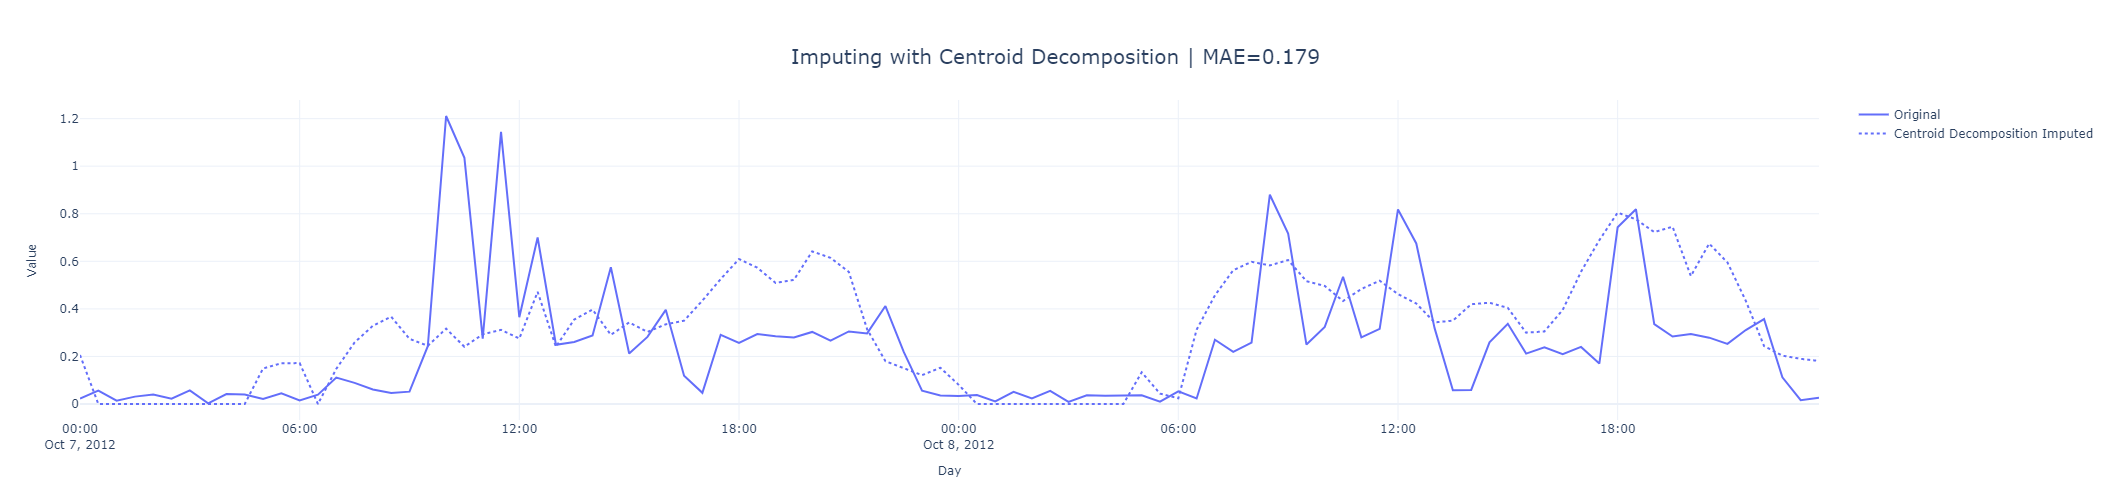

In [48]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','cdrec_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Centroid Decomposition | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Centroid Decomposition Imputed'])
fig.write_image("imgs/chapter_2/cdrec_imputation.png")
fig

#### Bonus: Seasonal Matrix Recovery

Sometimes, if we want to enforce a seasonal pattern, we can perform separate matrix recovery for sub sections of the data so that the recoovery only happens looking at the patterns in those subsections only. Here, we can try doing a matrix recovery  by taking each weekday separately.

In [49]:
def seasonal_matrix_recovery(rec_alg, df):
    recovered_matrix_cdrec = rec_alg.fit_transform(df.values)
    # Casting the array as the dataframe
    return pd.DataFrame(recovered_matrix_cdrec, columns=df.columns, index=df.index)

In [56]:
ts_df.drop(columns=["seasonal_cdrec", "seasonal_cdrec_imputed"], inplace=True)

In [57]:
filled_df = all_ts_df.groupby(all_ts_df.index.weekday).apply(
    lambda x: seasonal_matrix_recovery(
        rec_alg = CentroidRecovery(truncation=5, 
                         max_iters=100, 
                         init_fill_method="interpolate", 
                         min_value=0, 
                         early_stopping=True), 
        df = x))
#Joining with the ts_df and renaming the column
ts_df = ts_df.join(filled_df.loc[:, "MAC000193"])
ts_df.rename(columns={"MAC000193": "seasonal_cdrec_recovered"}, inplace=True)
# Using the nf recovered to fill missing
ts_df['seasonal_cdrec_imputed'] = ts_df.energy_consumption_missing
ts_df.loc[null_mask,"seasonal_cdrec_imputed"] = ts_df.loc[null_mask,"seasonal_cdrec_recovered"]
mae = mean_absolute_error(ts_df.loc[window, "seasonal_cdrec_imputed"], ts_df.loc[window, "energy_consumption"])

[CentroidRecovery] Iter 2: observed MAE=0.152676 Best Iteration: 2 Best MAE: 0.152676
[CentroidRecovery] Iter 3: observed MAE=0.143896 Best Iteration: 3 Best MAE: 0.143896
[CentroidRecovery] Iter 4: observed MAE=0.140819 Best Iteration: 4 Best MAE: 0.140819
[CentroidRecovery] Iter 5: observed MAE=0.138470 Best Iteration: 5 Best MAE: 0.138470
[CentroidRecovery] Iter 6: observed MAE=0.137556 Best Iteration: 6 Best MAE: 0.137556
[CentroidRecovery] Iter 7: observed MAE=0.137243 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Iter 8: observed MAE=0.137232 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Iter 9: observed MAE=0.137819 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Iter 10: observed MAE=0.138663 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Iter 11: observed MAE=0.139666 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Iter 12: observed MAE=0.140480 Best Iteration: 7 Best MAE: 0.137243
[CentroidRecovery] Early Stopping after 13 iteratio

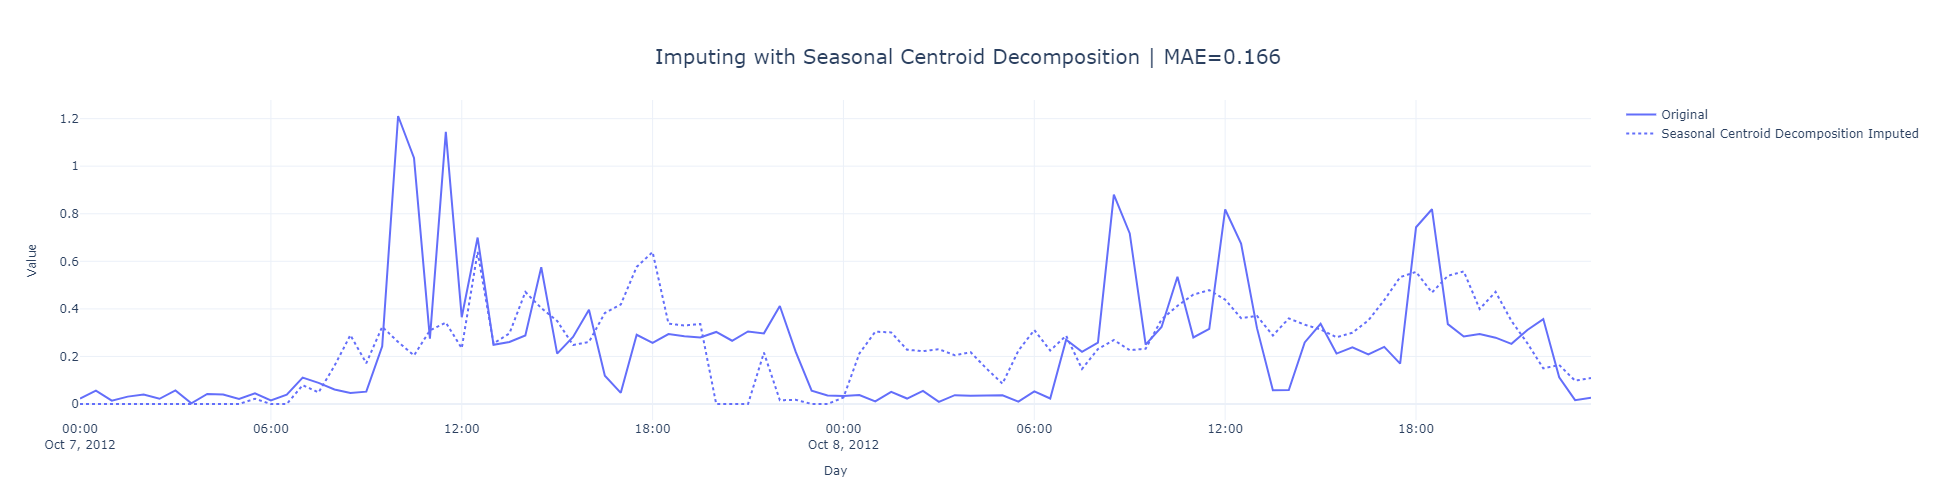

In [58]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','seasonal_cdrec_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Seasonal Centroid Decomposition | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Seasonal Centroid Decomposition Imputed'])
fig.write_image("imgs/chapter_2/seasonal_cdrec_imputation.png")
fig

### Summary

In [72]:
imputed_columns = [col for col in ts_df.columns if "imputed" in col]
original_col = "energy_consumption"

In [74]:
act = ts_df.loc[window, original_col].values
mae_d = {}
for col in imputed_columns:
    mae_d[col] = mean_absolute_error(act, ts_df.loc[window, col].values)

In [75]:
res_df = pd.DataFrame.from_dict(mae_d, orient="index").reset_index()
res_df.columns=["Imputation", "MAE"]
res_df.Imputation = res_df.Imputation.map({
 'prev_day_imputed': "Previous Day",
 'hourly_profile_imputed': "Hourly Profile",
 'day_hourly_profile_imputed': "Day-Hourly Profile",
    'seas_interp_weekday_half_hour_imputed': "Seasonal Interpolation Weekday-Half Hourly",
 'seas_interp_half_hour_imputed': "Seasonal Interpolation Half Hourly",
 'mf_50_imputed': "Matrix Factorization",
 'tsvd_imputed': "Truncated SVD",
 'isvd_imputed': "Iterative SVD",
 'si_imputed': "Soft Impute",
 'cdrec_imputed': "Centroid Recovery",
    'seasonal_cdrec_imputed': "Seasonal Centroid Recovery",
})

In [76]:
res_df

Imputation       MAE
0                                 Previous Day  0.167896
1                               Hourly Profile  0.121825
2                           Day-Hourly Profile  0.117431
3   Seasonal Interpolation Weekday-Half Hourly  0.120205
4           Seasonal Interpolation Half Hourly  0.122221
5                         Matrix Factorization  0.166700
6                                Truncated SVD  0.161365
7                                Iterative SVD  0.170155
8                                  Soft Impute  0.151844
9                            Centroid Recovery  0.179334
10                  Seasonal Centroid Recovery  0.166414

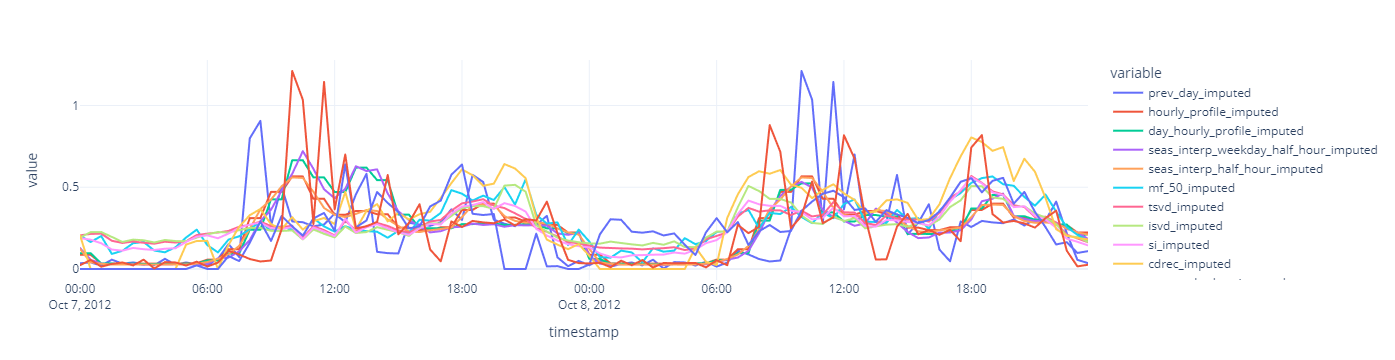

In [77]:
px.line(ts_df.loc[window, imputed_columns+[original_col]].reset_index(), x="timestamp", y=imputed_columns+[original_col])